In [4]:
!pip install h5py

In [5]:
pip install dask


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xarray h5netcdf h5py netcdf4



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install geopandas


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install rasterio


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. Data Extraction

In [9]:
# ==========================
# 1. Imports et SSL
# ==========================
import ssl
import os
import warnings
import pandas as pd
import xarray as xr
import earthaccess
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# ==========================
# 2. Environment variables used for login
# ==========================
os.environ['EARTHDATA_USERNAME'] = 'tnourlyn'
os.environ['EARTHDATA_PASSWORD'] = 'Lutinette2411%'


In [11]:

# ==========================
# 3. EarthAccess authentification
# ==========================
try:
    auth = earthaccess.login(strategy="environment")
    print("✅ Authentification réussie !")
except Exception as e:
    print(f"❌ Échec de login : {e}")


✅ Authentification réussie !


In [12]:
# Deactivate SSL verification for Mac users 
import earthaccess, os

# Deactivate ssl in a fsspec session used by earthaccess
earthaccess.__store__.get_fsspec_session().kwargs['ssl'] = False
os.environ['FSSPEC_HTTP_VERIFY'] = 'False'

import certifi
import ssl
ssl_context = ssl.create_default_context(cafile=certifi.where())

In [19]:

# ==========================
# 4. Granules Search
# ==========================
minlon = 2.69170169436 #Bouding box info for Nigeria -- To change depending on chosen country 
maxlon = 14.5771777686
minlat = 4.24059418377
maxlat = 13.8659239771

#a granule contains the data for the bounding box for 1 month of a year 
granules = earthaccess.search_data(
    short_name='FLDAS_NOAH01_C_GL_M',
    temporal=("2020-01", "2024-12"),
    bounding_box=(minlon, minlat, maxlon, maxlat)
)
print(f"Granules found : {len(granules)}")


Granules found : 60


In [20]:
# ==========================
# 5. Data Opening # test for 1 year 
# ==========================

fn_list = earthaccess.open(granules)

ds = xr.open_dataset(fn_list[0], engine='h5netcdf') 
print(ds)


QUEUEING TASKS | : 100%|██████████| 60/60 [00:00<00:00, 8317.08it/s]
PROCESSING TASKS | : 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]
COLLECTING RESULTS | : 100%|██████████| 60/60 [00:00<00:00, 215092.51it/s]


<xarray.Dataset> Size: 605MB
Dimensions:                 (time: 1, bnds: 2, Y: 1500, X: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2020-01-01
  * Y                       (Y) float64 12kB -59.95 -59.85 ... 89.85 89.95
  * X                       (X) float64 29kB -179.9 -179.8 ... 179.9 180.0
Dimensions without coordinates: bnds
Data variables: (12/29)
    time_bnds               (time, bnds) datetime64[ns] 16B ...
    Evap_tavg               (time, Y, X) float32 22MB ...
    LWdown_f_tavg           (time, Y, X) float32 22MB ...
    Lwnet_tavg              (time, Y, X) float32 22MB ...
    Psurf_f_tavg            (time, Y, X) float32 22MB ...
    Qair_f_tavg             (time, Y, X) float32 22MB ...
    ...                      ...
    SoilMoi40_100cm_tavg    (time, Y, X) float32 22MB ...
    SoilMoi100_200cm_tavg   (time, Y, X) float32 22MB ...
    SoilTemp00_10cm_tavg    (time, Y, X) float32 22MB ...
    SoilTemp10_40cm_tavg    (time, Y, X) float32 22MB ...

We can open the first granule, containing all the data for january 2021

In [21]:
#Let's create a list of variables : 
varNames =[
    'Evap_tavg',
    'LWdown_f_tavg',
    'Lwnet_tavg',
    'Psurf_f_tavg',
    'Qair_f_tavg',
    'Qg_tavg',
    'Qh_tavg',
    'Qle_tavg',
    'Qs_tavg',
    'Qsb_tavg',
    'RadT_tavg',
    'Rainf_f_tavg',
    'SWE_inst',
    'SWdown_f_tavg',
    'SnowCover_inst',
    'SnowDepth_inst',
    'Snowf_tavg',
    'Swnet_tavg',
    'Tair_f_tavg',
    'Wind_f_tavg',
    'SoilMoi00_10cm_tavg',
    'SoilMoi10_40cm_tavg',
    'SoilMoi40_100cm_tavg',
    'SoilMoi100_200cm_tavg',
    'SoilTemp00_10cm_tavg',
    'SoilTemp10_40cm_tavg',
    'SoilTemp40_100cm_tavg',
    'SoilTemp100_200cm_tavg'
]

In [22]:
#We select the variables within the bouding box:

ds_sel = ds[varNames].where(
    (ds.X >= minlon) & (ds.X <= maxlon) &
    (ds.Y >= minlat) & (ds.Y <= maxlat),
    drop=True 
)
df_NASA = ds_sel.to_dataframe().reset_index()

2. Dataframe creation (for 1 granule)

Let's create the data frame thanks to the extracted data 

In [23]:
df_NASA.head()

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,Tair_f_tavg,Wind_f_tavg,SoilMoi00_10cm_tavg,SoilMoi10_40cm_tavg,SoilMoi40_100cm_tavg,SoilMoi100_200cm_tavg,SoilTemp00_10cm_tavg,SoilTemp10_40cm_tavg,SoilTemp40_100cm_tavg,SoilTemp100_200cm_tavg
0,2020-01-01,4.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,4.25,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,4.25,2.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,4.25,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,4.25,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_NASA.isna().sum()

time                        0
Y                           0
X                           0
Evap_tavg                 672
LWdown_f_tavg             633
Lwnet_tavg                672
Psurf_f_tavg              633
Qair_f_tavg               633
Qg_tavg                   672
Qh_tavg                   672
Qle_tavg                  672
Qs_tavg                   672
Qsb_tavg                  672
RadT_tavg                 672
Rainf_f_tavg              633
SWE_inst                  672
SWdown_f_tavg             633
SnowCover_inst            672
SnowDepth_inst            672
Snowf_tavg                672
Swnet_tavg                672
Tair_f_tavg               633
Wind_f_tavg               633
SoilMoi00_10cm_tavg       672
SoilMoi10_40cm_tavg       672
SoilMoi40_100cm_tavg      672
SoilMoi100_200cm_tavg     672
SoilTemp00_10cm_tavg      672
SoilTemp10_40cm_tavg      672
SoilTemp40_100cm_tavg     672
SoilTemp100_200cm_tavg    672
dtype: int64

3. Spatial aggregation

In [25]:
import geopandas as gpd
from shapely.geometry import Point

admin2_gdf = gpd.read_file("gadm41_NGA_2.json")

#Convert pixels into Point geometries

gdf_pixels = gpd.GeoDataFrame(
    df_NASA, 
    geometry = gpd.points_from_xy(df_NASA['X'], df_NASA['Y']),
    crs = admin2_gdf.crs
)

gdf_pixels.head()
admin2_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
print(gdf_pixels.crs)
print(admin2_gdf.crs)

EPSG:4326
EPSG:4326


In [27]:

gdf_joined = gpd.sjoin(
    gdf_pixels,
    admin2_gdf,
    how="left",
    predicate="within"
)

In [28]:
print(df_NASA.shape)
print(gdf_joined.shape)

(11543, 31)
(11544, 46)


In [29]:
print(gdf_joined.columns)

Index(['time', 'Y', 'X', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg',
       'Psurf_f_tavg', 'Qair_f_tavg', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',
       'Qs_tavg', 'Qsb_tavg', 'RadT_tavg', 'Rainf_f_tavg', 'SWE_inst',
       'SWdown_f_tavg', 'SnowCover_inst', 'SnowDepth_inst', 'Snowf_tavg',
       'Swnet_tavg', 'Tair_f_tavg', 'Wind_f_tavg', 'SoilMoi00_10cm_tavg',
       'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg',
       'SoilTemp00_10cm_tavg', 'SoilTemp10_40cm_tavg', 'SoilTemp40_100cm_tavg',
       'SoilTemp100_200cm_tavg', 'geometry', 'index_right', 'GID_2', 'GID_0',
       'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2',
       'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2'],
      dtype='object')


In [30]:
gdf_joined['NAME_2'].isna().value_counts()

NAME_2
False    7491
True     4053
Name: count, dtype: int64

In [31]:
gdf_joined[gdf_joined['NAME_2'].isna()]

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,2020-01-01,4.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,4.25,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,4.25,2.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,4.25,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,4.25,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11538,2020-01-01,13.85,14.15,0.000002,299.593292,-118.895256,98268.679688,0.002965,-3.358937,52.355423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11539,2020-01-01,13.85,14.25,0.000004,299.279724,-117.760147,98200.593750,0.002972,-2.773172,46.954391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11540,2020-01-01,13.85,14.35,0.000003,299.079956,-117.618881,98168.632812,0.002981,-2.748152,46.144669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11541,2020-01-01,13.85,14.45,0.000003,298.885742,-117.519440,98123.625000,0.002982,-2.685239,46.080368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


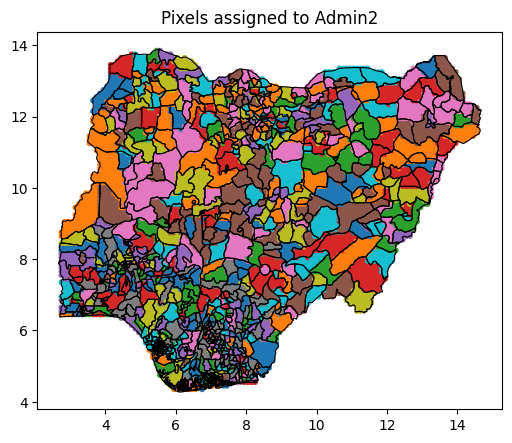

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot Admin2 boundaries
admin2_gdf.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot pixels (sample only, for speed)
gdf_joined.plot(
    ax=ax,
    column="NAME_2",
    legend=False,
    markersize=10
)

plt.title("Pixels assigned to Admin2")
plt.show()

6. Converting the data into a CSV 

In [33]:
df_NASA.to_csv(
    "FLDAS_Nigeria_pixels_2021.csv",
    index=False
)

print("✅ df_NASA exported to FLDAS_Nigeria_pixels_2021.csv")

✅ df_NASA exported to FLDAS_Nigeria_pixels_2021.csv


In [34]:
gdf_joined.to_csv(
    "geodata_FLDAS_Nigeria.csv",
    index= False
)

print("✅ gdf_joined exported to geodata_FLDAS_Nigeria_2021.csv")


✅ gdf_joined exported to geodata_FLDAS_Nigeria_2021.csv


7. Creation of the data for all 60 granules

We choose to use a for loop because extracting all the data at once takes too long processing 

In [36]:
try : 
    dfs = []

    for fn in fn_list : #We create a loop to open each granule individually
        ds = xr.open_dataset(fn, engine='h5netcdf')
        ds_sel = ds[varNames].where(
            (ds.X >= minlon) & (ds.X <= maxlon) &
            (ds.Y >= minlat) & (ds.Y <= maxlat),
        drop=True 
        )
        df_temp = ds_sel.to_dataframe().reset_index()
        dfs.append(df_temp)

    df_NASA_full = pd.concat(dfs, ignore_index = True)

    print("Dataframe sucessfully created")

except Exception as e : 
    print("Error in dataframe creation")


Dataframe sucessfully created


In [37]:
df_NASA_full.head()

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,Tair_f_tavg,Wind_f_tavg,SoilMoi00_10cm_tavg,SoilMoi10_40cm_tavg,SoilMoi40_100cm_tavg,SoilMoi100_200cm_tavg,SoilTemp00_10cm_tavg,SoilTemp10_40cm_tavg,SoilTemp40_100cm_tavg,SoilTemp100_200cm_tavg
0,2020-01-01,4.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,4.25,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,4.25,2.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,4.25,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,4.25,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Convert pixels into Point geometries 

gdf_pixels_full = gpd.GeoDataFrame(
    df_NASA_full, 
    geometry = gpd.points_from_xy(df_NASA_full['X'], df_NASA_full['Y']),
    crs = admin2_gdf.crs
)

gdf_pixels_full.head()
admin2_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
gdf_joined_full = gpd.sjoin(
    gdf_pixels_full,
    admin2_gdf,
    how="left",
    predicate="within"
)

In [40]:
gdf_joined_full.head()

,time,Y,X,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,Psurf_f_tavg,Qair_f_tavg,Qg_tavg,Qh_tavg,...,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2
0,2020-01-01,4.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,4.25,2.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,4.25,2.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,4.25,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,4.25,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
gdf_joined_full.isna().sum()

time                           0
Y                              0
X                              0
Evap_tavg                  40320
LWdown_f_tavg              37980
Lwnet_tavg                 40320
Psurf_f_tavg               37980
Qair_f_tavg                37980
Qg_tavg                    40320
Qh_tavg                    40320
Qle_tavg                   40320
Qs_tavg                    40320
Qsb_tavg                   40320
RadT_tavg                  40320
Rainf_f_tavg               37980
SWE_inst                   40320
SWdown_f_tavg              37980
SnowCover_inst             40320
SnowDepth_inst             40320
Snowf_tavg                 40320
Swnet_tavg                 40320
Tair_f_tavg                37980
Wind_f_tavg                37980
SoilMoi00_10cm_tavg        40320
SoilMoi10_40cm_tavg        40320
SoilMoi40_100cm_tavg       40320
SoilMoi100_200cm_tavg      40320
SoilTemp00_10cm_tavg       40320
SoilTemp10_40cm_tavg       40320
SoilTemp40_100cm_tavg      40320
SoilTemp10

In [42]:
gdf_joined_full['NAME_2'].isna().value_counts()

NAME_2
False    449460
True     243180
Name: count, dtype: int64

We find the same proportion of na in the NAME_2 column as with the test dataframe (only for 01/2021). Let's convert both dataframes into csv for later use

In [43]:
#Converting both df into csv
df_NASA_full.to_csv("FLDAS_Nigeria_pixels_full.csv", index = False)
gdf_joined_full.to_csv("geodata_FLDAS_Nigeria_full.csv", index = False)

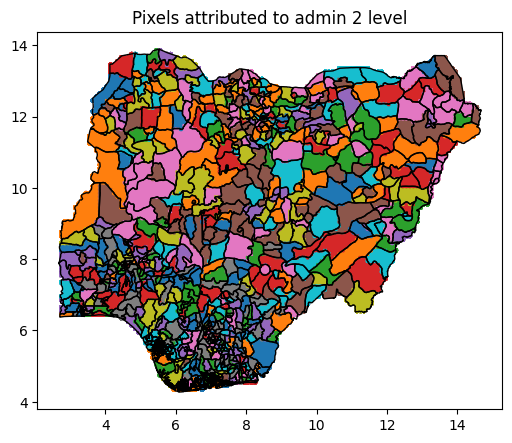

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Carte du Nigeria (polygone)
admin2_gdf.boundary.plot(
    ax=ax,
    linewidth=1,
    color="black"
)

# Tous les pixels (aucun filtrage)
gdf_joined_full.plot(
    ax=ax,
    markersize=5,
    column="NAME_2",
    legend = False,
)

plt.title("Pixels attributed to admin 2 level")
plt.show()